# Evaluation of Binary Beat Estimation from Beats in 3/4 obtained by Beat Tracking Algorithms
by:

Jose R. Zapata and Antonio Escamilla

**Project ACMUS:**  https://acmus-mir.github.io/

## Installing libraries and import statements

In [1]:
!python -m pip install madmom -q                                                # Package for beat analysis

     |████████████████████████████████| 20.0 MB 1.2 MB/s 
     |████████████████████████████████| 51 kB 5.8 MB/s 


In [2]:
import sys
import os
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import madmom
import madmom.evaluation.beats as be
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] =(12,6)

## Get Generated Beat Data, Audiofiles and Annotations

**Download Generated Beat Data from AcMus GDrive:**

https://drive.google.com/file/d/1-OoQc0SnH2a5paSyE055NV3BG9cXQIWV/view?usp=sharing

**To use wget, we modified the above link as follows:**

copy the link provided and replace the `file/d/` with `uc?id=` and replace at the end of the link the `/view?usp=sharing` with `&export=download`. 

In [3]:
#Download files from GDrive (public access)
!wget -O bambucos_generated_beats_compound.zip https://drive.google.com/uc?id=1-OoQc0SnH2a5paSyE055NV3BG9cXQIWV&export=download

--2021-09-16 11:15:49--  https://drive.google.com/uc?id=1-OoQc0SnH2a5paSyE055NV3BG9cXQIWV
Resolving drive.google.com (drive.google.com)... 172.217.204.139, 172.217.204.138, 172.217.204.101, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-7o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/brob0jn83u1i31p85rsbmiuf4ckfv32i/1631790900000/14014920541761407995/*/1-OoQc0SnH2a5paSyE055NV3BG9cXQIWV [following]
--2021-09-16 11:15:49--  https://doc-08-7o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/brob0jn83u1i31p85rsbmiuf4ckfv32i/1631790900000/14014920541761407995/*/1-OoQc0SnH2a5paSyE055NV3BG9cXQIWV
Resolving doc-08-7o-docs.googleusercontent.com (doc-08-7o-docs.googleusercontent.com)... 173.194.213.132, 2607:f8b0:400c:c0a::84
Connecting to doc-08-7o-docs.googleusercontent.com (doc-08-7o-docs.googleusercontent.com)|1

In [4]:
#Unzip file
!unzip -q bambucos_generated_beats_compound.zip -d ./

In [5]:
# Directory in GDrive where the generated predictions are saved
generated_beats_dir = '/content/bambucos_generated_beats_compound/'             

In [6]:
# Get the list of Files in Folder
import glob, os
import shutil

In [7]:
# List all txt files in the folder
generated_beats_list = glob.glob(generated_beats_dir + '*.txt')

**Download Audio Files and Annotations from Zenodo:**

https://zenodo.org/record/3965447/files/rhythm_set.zip?download=1

In [8]:
#Download files from Zenodo
!wget -O rhythm_set.zip https://zenodo.org/record/3965447/files/rhythm_set.zip?download=1

--2021-09-16 11:15:50--  https://zenodo.org/record/3965447/files/rhythm_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1843834847 (1.7G) [application/octet-stream]
Saving to: ‘rhythm_set.zip’

rhythm_set.zip      100%[===================>]   1.72G  23.3MB/s    in 2m 54s  

2021-09-16 11:18:46 (10.1 MB/s) - ‘rhythm_set.zip’ saved [1843834847/1843834847]



In [9]:
#Unzip file
!unzip -q rhythm_set.zip -d ./rhythm_set

## Get bambucos information

In [10]:
anotations_dir='./rhythm_set/Beat_annotations/'                                 # Anotation files folder

In [11]:
bambuco_set = pd.DataFrame(columns=['sample_name','compound_ann', 'generated_beat_file'])

In [12]:
sample_names_list = []
for file_name in generated_beats_list:
    sample_names_list.append(file_name.split('/')[-1][:-11])                    # Grab sample name from fullpath 

In [13]:
bambuco_set['sample_name'] = sample_names_list
bambuco_set['compound_ann'] = bambuco_set['sample_name'].apply(lambda x: x)+'(1).txt'               # use sample name to complete file name for annotations   
bambuco_set['generated_beat_file'] = bambuco_set['sample_name'].apply(lambda x: x)+'_gen(1).txt'    # use sample name to complete file name for generated beats 
bambuco_set.reset_index(drop=True, inplace = True)
print(f'Number of Bambuco Files with generated beats= {len(bambuco_set)}')

Number of Bambuco Files with generated beats= 41


## Get Ground Truth

In [14]:
def read_ann(file):
  '''
  function to read .txt annotations file
  returns numpy array
  '''
  beatsItt = list()

  if 'gen' in file:                                 # if the 'gen' characters are included in the file string
    dir = generated_beats_dir                       # use the generated beats folder
  else:
    dir = anotations_dir                            #if not, use the annotations folder

  
  with open(os.path.join(dir, file), 'r') as f:
    lines= [line.split() for line in f]
    for line in lines:
      beatsItt.append(np.float32(line[0]))
    beatsItt=np.asarray(beatsItt)
    return beatsItt

In [15]:
bambuco_set['compound_gt'] = bambuco_set['compound_ann'].apply(read_ann)                        # read annotations in txt files and fill the data frame
bambuco_set['generated_beats'] = bambuco_set['generated_beat_file'].apply(read_ann)             # read generated beats in txt files and fill the data frame

In [16]:
bambuco_set.head()

,sample_name,compound_ann,generated_beat_file,compound_gt,generated_beats
0,rh_0055,rh_0055(1).txt,rh_0055_gen(1).txt,"[0.046666667, 0.6346667, 1.2646667, 1.8713334,...","[0.04, 0.655, 1.25, 1.855, 2.44, 3.0349998, 3...."
1,rh_0040,rh_0040(1).txt,rh_0040_gen(1).txt,"[0.021333333, 0.49066666, 1.0746666, 1.6, 2.09...","[0.505, 1.03, 1.5550001, 2.07, 2.6, 3.11, 3.62..."
2,rh_0179,rh_0179(1).txt,rh_0179_gen(1).txt,"[1.1146667, 1.7670625, 2.4053333, 3.036, 3.595...","[0.505, 1.12, 1.76, 2.37, 2.975, 3.58, 4.185, ..."
3,rh_0177,rh_0177(1).txt,rh_0177_gen(1).txt,"[0.39666668, 0.9633333, 1.455, 2.0332603, 2.55...","[0.42, 0.975, 1.5, 2.035, 2.55, 3.065, 3.57, 4..."
4,rh_0046,rh_0046(1).txt,rh_0046_gen(1).txt,"[0.10666667, 0.65066665, 1.216, 1.7493334, 2.3...","[0.14, 0.695, 1.23, 1.755, 2.29, 2.8400002, 3...."


## Beat Evaluation


### Madmom Evaluation


In [17]:
Rhythm_madmom = pd.DataFrame(columns=['sample_name'])               # create a new df with the 'sample name' 
Rhythm_madmom['sample_name'] = bambuco_set['sample_name']           # column from the 'bambuco_set' df

# Create columns by evaluation metrics
Rhythm_madmom['fmeasure']=''
Rhythm_madmom['amlc']=''
Rhythm_madmom['amlt']=''
Rhythm_madmom['cmlc']=''
Rhythm_madmom['cmlt']=''
Rhythm_madmom['Eval'] =''

In [23]:
for n, file in bambuco_set.iterrows():
  Rhythm_madmom['Eval'][n] = be.BeatEvaluation(file['generated_beats'], file['compound_gt'])    # run madmom evaluation using generated beats and compound ground truth
  Rhythm_madmom['fmeasure'][n]= Rhythm_madmom['Eval'][n].fmeasure*100                           # fill in all evaluation metrics
  Rhythm_madmom['amlc'][n]= Rhythm_madmom['Eval'][n].amlc*100
  Rhythm_madmom['amlt'][n]= Rhythm_madmom['Eval'][n].amlt*100
  Rhythm_madmom['cmlc'][n]= Rhythm_madmom['Eval'][n].cmlc*100
  Rhythm_madmom['cmlt'][n]= Rhythm_madmom['Eval'][n].cmlt*100

In [24]:
Rhythm_madmom[['fmeasure','amlc', 'amlt', 'cmlc', 'cmlt']] = Rhythm_madmom[['fmeasure', 'amlc', 'amlt', 'cmlc', 'cmlt']].apply(pd.to_numeric)

### Results


In [25]:
colu = ['fmeasure', 'amlc', 'amlt', 'cmlc', 'cmlt']
display(Rhythm_madmom[colu])

,fmeasure,amlc,amlt,cmlc,cmlt
0,96.969697,94.117647,94.117647,94.117647,94.117647
1,99.082569,98.181818,98.181818,98.181818,98.181818
2,76.470588,83.333333,83.333333,83.333333,83.333333
3,100.000000,100.000000,100.000000,100.000000,100.000000
4,100.000000,100.000000,100.000000,100.000000,100.000000
5,98.412698,96.875000,96.875000,96.875000,96.875000
6,100.000000,100.000000,100.000000,100.000000,100.000000
7,100.000000,100.000000,100.000000,100.000000,100.000000
8,95.652174,97.142857,97.142857,97.142857,97.142857
9,97.142857,100.000000,100.000000,100.000000,100.000000


In [26]:
Rhythm_madmom[colu].describe()

,fmeasure,amlc,amlt,cmlc,cmlt
count,41.000000,41.000000,41.000000,41.000000,41.000000
mean,92.135966,88.473307,91.598461,88.473307,91.598461
std,11.247544,16.287954,13.774359,16.287954,13.774359
min,52.459016,36.363636,36.363636,36.363636,36.363636
25%,91.891892,83.333333,93.750000,83.333333,93.750000
50%,96.842105,96.875000,96.875000,96.875000,96.875000
75%,98.795181,100.000000,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000


#### Boxplot


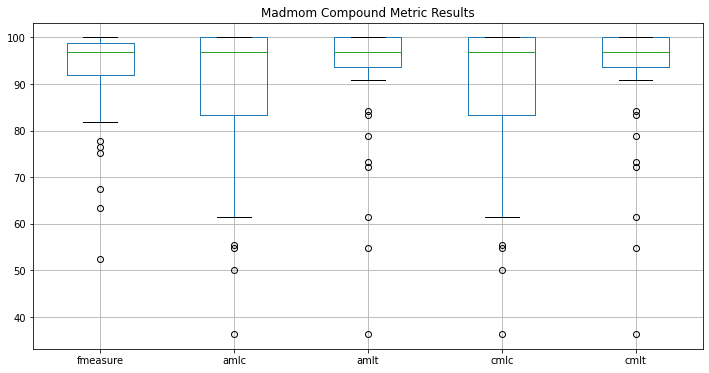

In [27]:
plt.rcParams["figure.figsize"] =(12,6) 
Rhythm_madmom[colu].boxplot()
plt.title('Madmom Compound Metric Results');